# Species Distribution Modelling:
## The Bin Chicken in Italy

The notebook follows the [Google Earth Engine tutorial](https://developers.google.com/earth-engine/tutorials/community/species-distribution-modeling), but instead of using the Google Earth Engine, we perform the analyse in Python because I think the code in GEE tends to get a bit messy and some lines are hard to understand. GEE is great for interactive maps and provides amazing tutorials, seriously check out the website and all the tutorials they have ranging from basics to quite advanced topics.

However, I want to create a blog post on my static website, so it'll be "basic" Python (rasterio and matplotlib). 

Double however, we will still be using GEE for the data collection because the easy access to data is just unbeatable. Downloading all the data/maps can be a bit annoying especially when some data is only available as a whole and has to be cropped afterwards. The bioclimatic Data from WorldClim for example is roughly 10GB.

So the plan is to first gather the data in GEE, do most of the data wrangling in there and then export it. The export is a bit complicated with how GEE works, but we are converting the raster data into a gdf and then save the gdf. This step takes quite some time, but I will also provide the data for download to skip this step.

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# 1 Collecting the Occurence Data

In the first step, we will collect all the required data. Starting with the environmental information, we want to gather the following information:
1. Elevation Data from SRTM (NASA)
2. Tree Canopy Cover from 
3. Bioclimatic Data from WorldClim

In [3]:
# Spatial resolution setting (meters)
grain_size = 3000

In [4]:
# Import libraries
# if you get errors here you should be able to just pip install the libraries

import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely.ops import unary_union
from shapely.geometry import Point

from geopandas.tools import sjoin
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

I have prepared the data set we are working with. It can be downloaded from https://gbif.org/
I have also provided an API approach to download data, but for some reason it did not work for the magical bin chickens. I only got 300 entries compared to 3,000.

In [ ]:
df = pd.read_excel("data/bin_chicken.xlsx")

In [6]:
df.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

## Collection and Preprocessing of Species Occurrence Data

Here is a code to collect data directly through the GBIF API taken from the [Google Earth Engine tutorial](https://developers.google.com/earth-engine/tutorials/community/species-distribution-modeling). The [GBIF API](https://techdocs.gbif.org/en/openapi/) is an interface that allows access to the species distribution data provided by GBIF, enabling users to search, filter, and download data, as well as acquire various information related to species.

In [7]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 100000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

You can try if it works for you, but I only get 300 entries

In [8]:
# Retrieve Bradypus variegatus data
#df = get_gbif_species_data("Threskiornis aethiopicus (Latham, 1790)", "IT")
#df = get_gbif_species_data("Bradypus variegatus")
#df  # Display the first row of the DataFrame

### 1.1 Data Cleaning

Let's slap some geometry on our dataframe and turn it into a geodataframe. I really love geopandas because it is very intuitive to use for pandas users.

In [9]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
gdf.head(2)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Threskiornis aethiopicus,2006,2,POINT (11.2842 42.42878)
1,Threskiornis aethiopicus,2025,5,POINT (12.32541 45.04476)


Here is a function to create heatmaps from the GEE tutorial. I think I have only created heatmaps with the seaborn library which would make this whole function a 2 liner, but why not use what is already coded up.

In [ ]:
# Yearly and monthly data distribution heatmap
def plot_heatmap(gdf, h_size=14):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # Heatmap
    plt.figure(figsize=(h_size, h_size - 6))
    heatmap = plt.imshow(
        statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
    )

    # Display values above each pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(
                j, i, statistics.values[i, j], ha="center", va="center", color="black"
            )

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig("output/heatmap_plot.png")
    plt.show()

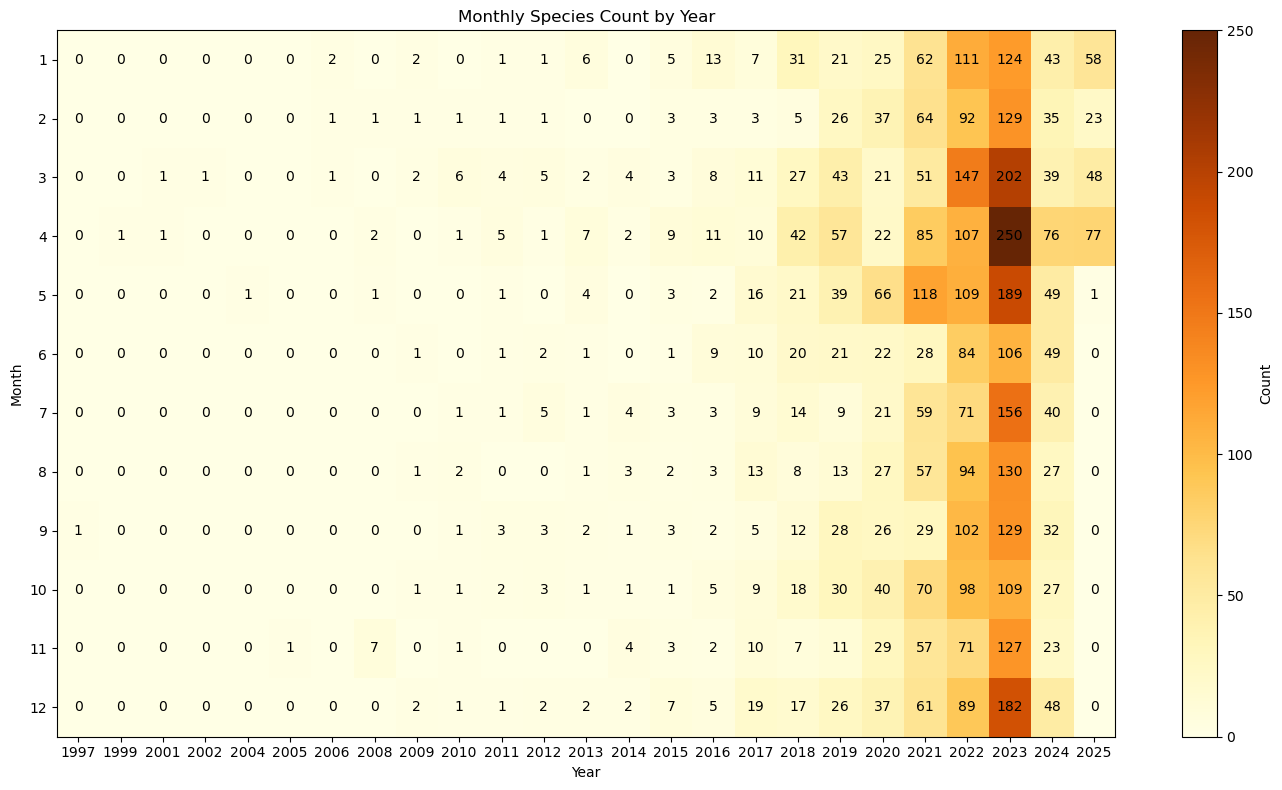

In [11]:
plot_heatmap(gdf)

There is very sparse information before 2015 and then 2023 was crazy. If we were to do any work with the time component, we might need to think about how to deal with these, but we should be fine just continuing like this

In [12]:
# Convert GeoDataFrame to Earth Engine object
data_raw = geemap.geopandas_to_ee(gdf)

Next, we will define the raster pixel size of the SDM results as 1km resolution.

In [13]:
# Spatial resolution setting (meters)
grain_size = 1000

In our analysis, we divide Italy into 1 square km cells and then decide if there has been a sighting in one of these cells or not. So if there are multiple sightings per cell, we can remove the duplicates. Or in other words, our sightings data will have the same resolution as our environmental variables.

In [14]:
# This could probably be done in the gdf, but well the code was already provided in the tutorial
def remove_duplicates(data, grain_size):
    # Select one occurrence record per pixel at the chosen spatial resolution
    random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
    rand_point_vals = random_raster.sampleRegions(
        collection=ee.FeatureCollection(data), geometries=True
    )
    return rand_point_vals.distinct("random")


data = remove_duplicates(data_raw, grain_size)

# Before selection and after selection
print("Original data size:", data_raw.size().getInfo())
print("Final data size:", data.size().getInfo())

Original data size: 5732
Final data size: 2035


### 1.2 Data Visualisation

The visualization comparing geographic sampling bias before preprocessing (in blue) and after preprocessing (in red) is shown below. To facilitate comparison, the map has been centered on the area with a high concentration of Fairy pitta occurrence coordinates in Hallasan National Park.

In [15]:
# And let's convert the GEE object back to a gdf.
gdf_species = geemap.ee_to_gdf(data)

We define our **Area of Interest (AOI)**. Ideally, we would get the outline of Italy, but a lazy solution is taking our occurence data and putting an 50km buffer around it. (We could think about using the Italian border instead, but a couple cells below I show how to use a shapefile to mask raster data)

In [16]:
# Define the AOI
aoi = data.geometry().bounds().buffer(distance=50000, maxError=1000)

# uncomment to check the bounds
'''
# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 6)
Map
'''

'\n# Add the AOI to the map\noutline = ee.Image().byte().paint(\n    featureCollection=aoi, color=1, width=3)\n\nMap.remove_layer("Random Raster")\nMap.addLayer(outline, {\'palette\': \'FF0000\'}, "AOI")\nMap.centerObject(aoi, 6)\nMap\n'

### (1.3 Optional) Animation showing the Sacred Ibis observations with time.

In [17]:
'''
from matplotlib.animation import FuncAnimation
import contextily as ctx  # for satellite background
import matplotlib.colors as mcolors

years = sorted(gdf_species['year'].unique())
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))

gdf_ani = gdf_species.to_crs(epsg=3857)

# Generate quarters and colors
gdf_ani['year_quarter'] = (
    pd.to_datetime(gdf[['year', 'month']].assign(day=1))
    .dt.to_period('Q')
    .astype(str)
)
quarters = sorted(gdf_ani['year_quarter'].unique())
colors = cm.viridis(np.linspace(0, 1, len(quarters)))
quarter_color_map = dict(zip(quarters, colors))

gdf_bounds = gdf_ani.total_bounds  # [minx, miny, maxx, maxy]

# Set up the figure
fig, ax = plt.subplots(figsize=(7, 7), dpi=72)


def update(frame):
    ax.clear()
    ax.set_xlim(gdf_bounds[0], gdf_bounds[2])
    ax.set_ylim(gdf_bounds[1], gdf_bounds[3])
    current_quarter = quarters[frame]
    for i, quarter in enumerate(quarters[:frame+1]):
        subset = gdf[gdf['year_quarter'] == quarter]
        subset.plot(ax=ax, color=quarter_color_map[quarter], markersize=10, label=quarter if i == frame else "")
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    #ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    ax.set_title(f"Ibis Spread: {current_quarter}", fontsize=16)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=len(quarters), repeat=False)

# Save animation
ani.save("ibis_spread_quarters.gif", writer='pillow', fps=2)

from IPython.display import HTML
HTML(ani.to_jshtml())
'''

'\nfrom matplotlib.animation import FuncAnimation\nimport contextily as ctx  # for satellite background\nimport matplotlib.colors as mcolors\n\nyears = sorted(gdf_species[\'year\'].unique())\ncmap = plt.cm.plasma\nnorm = mcolors.Normalize(vmin=min(years), vmax=max(years))\n\ngdf_ani = gdf_species.to_crs(epsg=3857)\n\n# Generate quarters and colors\ngdf_ani[\'year_quarter\'] = (\n    pd.to_datetime(gdf[[\'year\', \'month\']].assign(day=1))\n    .dt.to_period(\'Q\')\n    .astype(str)\n)\nquarters = sorted(gdf_ani[\'year_quarter\'].unique())\ncolors = cm.viridis(np.linspace(0, 1, len(quarters)))\nquarter_color_map = dict(zip(quarters, colors))\n\ngdf_bounds = gdf_ani.total_bounds  # [minx, miny, maxx, maxy]\n\n# Set up the figure\nfig, ax = plt.subplots(figsize=(7, 7), dpi=72)\n\n\ndef update(frame):\n    ax.clear()\n    ax.set_xlim(gdf_bounds[0], gdf_bounds[2])\n    ax.set_ylim(gdf_bounds[1], gdf_bounds[3])\n    current_quarter = quarters[frame]\n    for i, quarter in enumerate(quarters[

# 2 Addition of GEE environmental variables

Now, let's add environmental variables to the analysis. GEE provides a wide range of datasets for environmental variables such as temperature, precipitation, elevation, land cover, and terrain. These datasets enable us to comprehensively analyze various factors that may influence the habitat preferences of the Fairy pitta.

The selection of GEE environmental variables in SDM should reflect the habitat preference characteristics of the species. Should. We will use the standard set of variables and hope it will work. If we did some more research this would be a Nature publication. Let's keep it on a blog post tutorial level.


### 2.1 Download the Data

[**WorldClim V1 Bioclim**](https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO): This dataset provides 19 bioclimatic variables derived from monthly temperature and precipitation data. It covers the period from 1960 to 1991 and has a resolution of 927.67 meters.

In [18]:
# WorldClim V1 Bioclim
bio = ee.Image("WORLDCLIM/V1/BIO")

[**NASA SRTM Digital Elevation 30m**](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003): This dataset contains digital elevation data from the Shuttle Radar Topography Mission (SRTM). The data was primarily collected around the year 2000 and is provided at a resolution of approximately 30 meters (1 arc-second). The following code calculates elevation, slope, aspect, and hillshade layers from the SRTM data.

In [19]:
# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

[**Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m**](https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3): The Vegetation Continuous Fields (VCF) dataset from Landsat estimates the proportion of vertically projected vegetation cover when the vegetation height is greater than 5 meters. This dataset is provided for four time periods centered around the years 2000, 2005, 2010, and 2015, with a resolution of 30 meters. Here, the median values from these four time periods are used.

In [20]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
median_tcc = (
    tcc.filterDate("2000-01-01", "2020-12-31")
    .select(["tree_canopy_cover"], ["TCC"])
    .median()
)

### 2.2 Apply the water mask

As we are looking at birds, we are only interest in land habitat. One option is to use the elevation and everything below sea level is classified as water, but these birds love their wetlands. And wetlands can be below the sea level. Therefore, we are using land polygons that are also available on GEE and mask our image and clip to the aoi.

In [21]:
# Combine bands into a multi-band image
predictors = bio.addBands(terrain).addBands(median_tcc)

# Load land polygons (Natural Earth via Earth Engine)
land = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
    .filter(ee.Filter.neq("wld_rgn", "Ocean"))

land_masked_image = predictors.clipToCollection(land)

# Load land polygons (Natural Earth via Earth Engine)
italy_borders = ee.FeatureCollection("FAO/GAUL/2015/level0") \
    .filter(ee.Filter.eq('ADM0_NAME', 'Italy'))
predictors = land_masked_image.clipToCollection(italy_borders)

bbox = ee.Geometry.Rectangle([6.219524304531973, 36.60367679727342, 18.553063853943627, 47.157212045624846])
predictors = predictors.clip(bbox)

# Create land mask (invert water)
#land_mask = water_mask.Not()

# Create a water mask
watermask = terrain.select('elevation').gt(0)

# Mask out ocean pixels and clip to the area of interest
#predictors = predictors.updateMask(watermask).clip(aoi)

Let's visualise our data and if the mask is working. The area around Venice is a bit tricky because it is below see level.

The results look good enough.

In [22]:
# Let's check if our masking worked alright
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

image_viz_params = {
    'bands': ['elevation'],
    'min': -2.0,
    'max': 2500.0,
    'palette': ['0000ff','00ffff','ffff00','ff0000','ffffff']
}
Map.addLayer(predictors, image_viz_params, "Land Only Image")
# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Data")

# Set the center of the map to the coordinates
#Map.setCenter(126.712, 33.516, 14)
Map.centerObject(aoi, 5)
Map

Map(center=[41.85338927205686, 12.83692539095223], controls=(WidgetControl(options=['position', 'transparent_b…

### 2.3 Multicolinearity

Now, we take care of the correlation between our predictors variables. If there is a strong correlation between our variables, then this can mess with out regression modelling (see Multicollinearity). We reduce the predictor variables to only those that are not strongly correlated.

This also has the added side effect that our model will be easier to train with less dimensions.

The way to go is generate a large sample of random points (5,000 points for example) and extract the predictors at these points and calculate the correlation.

In [23]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grain_size, numPixels=10000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grain_size)

# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,3.0,35,134,92,35,5877,282,21,261,106,...,73,27,28,210,101,101,200,405,179,1
1,32.0,233,47,95,32,6623,197,-92,289,129,...,122,34,44,343,104,343,104,1552,202,8
2,7.5,103,120,80,30,6559,266,0,266,129,...,93,52,18,251,169,169,177,497,155,8
3,4.0,90,127,78,28,6770,274,0,274,121,...,86,35,27,225,134,148,134,297,180,0
4,10.5,328,123,98,35,6051,279,4,275,89,...,95,39,23,259,137,137,208,323,185,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,2.5,292,-5,62,28,5568,115,-104,219,-57,...,163,112,10,458,362,362,450,2511,219,13
2521,7.0,184,141,90,32,6291,289,16,273,110,...,93,44,22,268,155,156,209,165,181,2
2522,42.0,162,107,88,32,6503,261,-13,274,118,...,102,52,22,282,171,187,184,915,176,4
2523,0.0,305,-58,42,23,4940,35,-146,181,4,...,180,118,13,522,385,478,423,3323,195,6


Calculating Spearman correlation coefficients between the given predictor variables and visualizing them in a heatmap.

In [ ]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('output/correlation_heatmap_plot.png')
    plt.show()

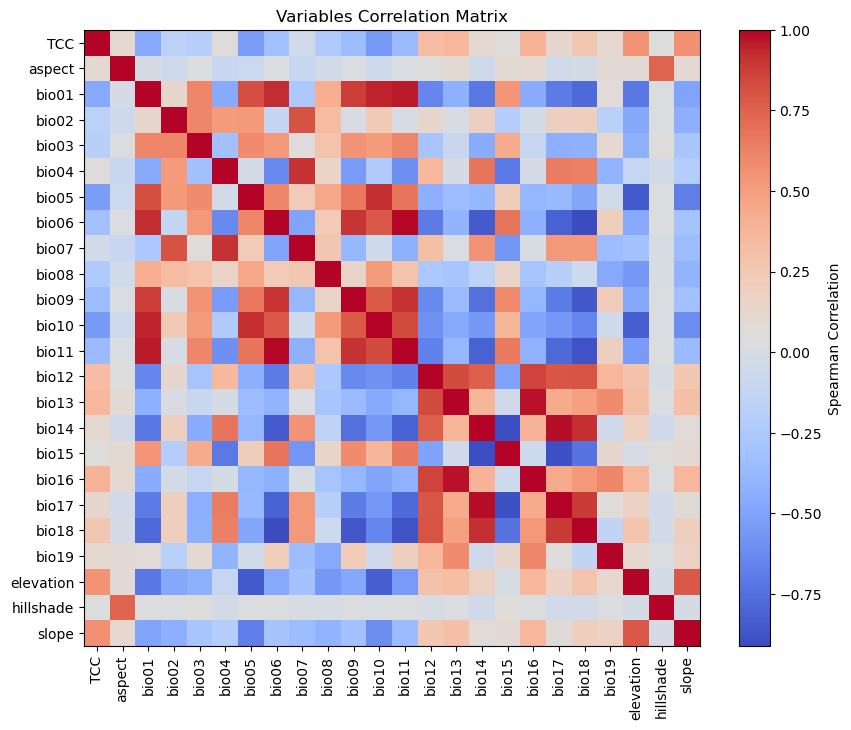

In [25]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

The go-to approach for variable selection with multicollinearity is the **Variance Inflation Factor (VIF)**. It indicates the degree of linear relationship of each independent variable with the other independent variables, where a high VIF values can be evidence of multicollinearity.

Usually, we don't want the VIF to exceed 5 or 10. We use 10 for now.

In [26]:
# Filter variables based on Variance Inflation Factor (VIF)
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [27]:
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df, 5)

Removing 'bio05' with VIF inf
Removing 'bio10' with VIF 191093.05
Removing 'bio07' with VIF 25953.31
Removing 'bio01' with VIF 18212.53
Removing 'bio12' with VIF 1813.15
Removing 'bio11' with VIF 1514.01
Removing 'bio16' with VIF 1198.53
Removing 'bio03' with VIF 1167.12
Removing 'bio17' with VIF 362.60
Removing 'bio13' with VIF 183.89
Removing 'bio04' with VIF 173.50
Removing 'hillshade' with VIF 89.64
Removing 'bio02' with VIF 67.72
Removing 'bio18' with VIF 52.18
Removing 'bio15' with VIF 39.78
Removing 'bio19' with VIF 23.13
Removing 'bio09' with VIF 9.62
Removing 'bio08' with VIF 7.49
Removing 'elevation' with VIF 5.00
Bands: ['TCC', 'aspect', 'bio06', 'bio14', 'slope']


In [28]:
bands = ['TCC', 'aspect', 'bio06','bio09', 'bio14', 'elevation', 'slope']

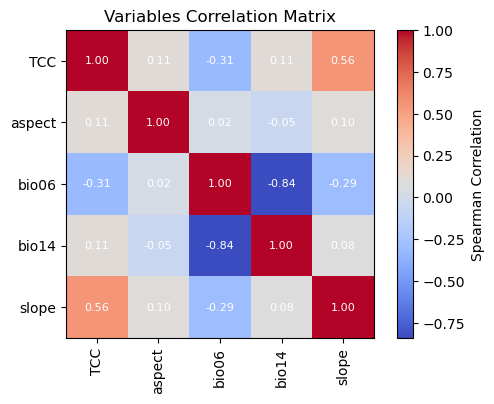

In [29]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

The next step will take forever. I don't know why but sampling from a geemap image and converting to a dataframe takes forever. We will have a big dataset, but not huge. With a 1km resolution, we should be getting around 0.1GB of data.

This step is commented out and you can just load in the data I provided. It should load in less than 1min.

### 2.4 Store the Data

In [30]:
#predictors_feature = predictors.sample(region=bbox, scale=1000, geometries=True) 
#gdf = geemap.ee_to_gdf(predictors_feature)
#gdf.to_file('dataframe.geojson', driver='GeoJSON')  
# Load data
#gdf_predictors = gpd.read_file('dataframe.geojson')

In [31]:
# Load data
gdf_predictors = gpd.read_file('dataframe.geojson')

In [32]:
# The relevant predictors might be different from the random sample compared to when I did it. Strongly correlated predictors might have been swapped
bands = [col for col in gdf_predictors.columns if col not in ["geometry"]]

gdf_predictors

,TCC,aspect,bio06,bio09,bio14,elevation,slope,geometry
0,0.0,229,-137,27,151,3008,16,POINT (6.79576 45.8006)
1,0.5,276,-143,20,155,3354,25,POINT (6.80474 45.8006)
2,0.5,18,-156,2,162,3638,4,POINT (6.81372 45.8006)
3,1.0,60,-139,23,153,3326,31,POINT (6.8227 45.8006)
4,3.0,58,-117,57,139,2923,36,POINT (6.83169 45.8006)
...,...,...,...,...,...,...,...,...
410038,43.5,244,13,57,74,171,1,POINT (13.6499 45.79162)
410039,47.5,277,12,55,74,181,1,POINT (13.65888 45.79162)
410040,48.5,326,12,55,74,189,1,POINT (13.66787 45.79162)
410041,47.5,325,11,55,75,195,1,POINT (13.67685 45.79162)


### (2.5 optional) Visualising the different predictor Variables

This section is optional and purely for visualisation (maybe a bit of understanding of our aoi). You can skip this section.

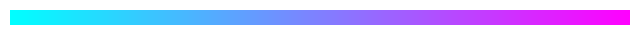

In [33]:
cm.plot_colormap('cool', width=8.0, height=0.2, orientation='horizontal')

In [34]:
# Elevation layer
'''
Map = geemap.Map(layout={'height':'400px', 'width':'500px'})

vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(bbox, 5)
Map'''


'\nMap = geemap.Map(layout={\'height\':\'400px\', \'width\':\'500px\'})\n\nvis_params = {\'bands\':[\'elevation\'], \'min\': 0, \'max\': 1800, \'palette\': cm.palettes.terrain}\nMap.addLayer(predictors, vis_params, \'elevation\')\nMap.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")\nMap.centerObject(bbox, 5)\nMap'

In [35]:
# Calculate the minimum and maximum values for bio09
'''
min_max_val = (
    predictors.select("bio09")
    .multiply(0.1)
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio09 (Mean temperature of driest quarter) layer
Map = geemap.Map(layout={"height": "400px", "width": "500px"})

vis_params = {
    "min": math.floor(min_max_val["bio09_min"]),
    "max": math.ceil(min_max_val["bio09_max"]),
    "palette": cm.palettes.hot,
}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, "bio09")
Map.add_colorbar(
    vis_params,
    label="Mean temperature of driest quarter (℃)",
    orientation="vertical",
    layer_name="bio09",
)
Map.centerObject(bbox, 5)
Map
'''

'\nmin_max_val = (\n    predictors.select("bio09")\n    .multiply(0.1)\n    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)\n    .getInfo()\n)\n\n# bio09 (Mean temperature of driest quarter) layer\nMap = geemap.Map(layout={"height": "400px", "width": "500px"})\n\nvis_params = {\n    "min": math.floor(min_max_val["bio09_min"]),\n    "max": math.ceil(min_max_val["bio09_max"]),\n    "palette": cm.palettes.hot,\n}\nMap.addLayer(predictors.select("bio09").multiply(0.1), vis_params, "bio09")\nMap.add_colorbar(\n    vis_params,\n    label="Mean temperature of driest quarter (℃)",\n    orientation="vertical",\n    layer_name="bio09",\n)\nMap.centerObject(bbox, 5)\nMap\n'

In [36]:
'''
# Calculate the minimum and maximum values for bio06
min_max_val = (
    predictors.select("bio06")
    .multiply(0.1)
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio09 (Mean temperature of driest quarter) layer
Map = geemap.Map(layout={"height": "400px", "width": "500px"})

vis_params = {
    "min": math.floor(min_max_val["bio06_min"]),
    "max": math.ceil(min_max_val["bio06_max"]),
    "palette": cm.palettes.RdYlBu_r,
}
Map.addLayer(predictors.select("bio06").multiply(0.1), vis_params, "bio06")
Map.add_colorbar(
    vis_params,
    label="Min Temperature of Coldest Month (℃)",
    orientation="vertical",
    layer_name="bio06",
)
Map.centerObject(bbox, 5)
Map
'''

'\n# Calculate the minimum and maximum values for bio06\nmin_max_val = (\n    predictors.select("bio06")\n    .multiply(0.1)\n    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)\n    .getInfo()\n)\n\n# bio09 (Mean temperature of driest quarter) layer\nMap = geemap.Map(layout={"height": "400px", "width": "500px"})\n\nvis_params = {\n    "min": math.floor(min_max_val["bio06_min"]),\n    "max": math.ceil(min_max_val["bio06_max"]),\n    "palette": cm.palettes.RdYlBu_r,\n}\nMap.addLayer(predictors.select("bio06").multiply(0.1), vis_params, "bio06")\nMap.add_colorbar(\n    vis_params,\n    label="Min Temperature of Coldest Month (℃)",\n    orientation="vertical",\n    layer_name="bio06",\n)\nMap.centerObject(bbox, 5)\nMap\n'

In [37]:
'''
# Slope layer
Map = geemap.Map(layout={'height':'400px', 'width':'500px'})

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(bbox, 5)
Map
'''

'\n# Slope layer\nMap = geemap.Map(layout={\'height\':\'400px\', \'width\':\'500px\'})\n\nvis_params = {\'bands\':[\'slope\'], \'min\': 0, \'max\': 25, \'palette\': cm.palettes.RdYlGn_r}\nMap.addLayer(predictors, vis_params, \'slope\')\nMap.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")\nMap.centerObject(bbox, 5)\nMap\n'

In [38]:
'''
# Aspect layer
Map = geemap.Map(layout={'height':'400px', 'width':'500px'})

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(bbox, 5)
Map
'''


'\n# Aspect layer\nMap = geemap.Map(layout={\'height\':\'400px\', \'width\':\'500px\'})\n\nvis_params = {\'bands\':[\'aspect\'], \'min\': 0, \'max\': 360, \'palette\': cm.palettes.rainbow}\nMap.addLayer(predictors, vis_params, \'aspect\')\nMap.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")\nMap.centerObject(bbox, 5)\nMap\n'

In [39]:
'''
# Calculate the minimum and maximum values for bio14
min_max_val = (
    predictors.select("bio14")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio14 (Precipitation of driest month) layer
Map = geemap.Map(layout={"height": "400px", "width": "500px"})

vis_params = {
    "bands": ["bio14"],
    "min": math.floor(min_max_val["bio14_min"]),
    "max": math.ceil(min_max_val["bio14_max"]),
    "palette": cm.palettes.Blues,
}
Map.addLayer(predictors, vis_params, "bio14")
Map.add_colorbar(
    vis_params,
    label="Precipitation of driest month (mm)",
    orientation="vertical",
    layer_name="bio14",
)
Map.centerObject(bbox, 5)
Map
'''

'\n# Calculate the minimum and maximum values for bio14\nmin_max_val = (\n    predictors.select("bio14")\n    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)\n    .getInfo()\n)\n\n# bio14 (Precipitation of driest month) layer\nMap = geemap.Map(layout={"height": "400px", "width": "500px"})\n\nvis_params = {\n    "bands": ["bio14"],\n    "min": math.floor(min_max_val["bio14_min"]),\n    "max": math.ceil(min_max_val["bio14_max"]),\n    "palette": cm.palettes.Blues,\n}\nMap.addLayer(predictors, vis_params, "bio14")\nMap.add_colorbar(\n    vis_params,\n    label="Precipitation of driest month (mm)",\n    orientation="vertical",\n    layer_name="bio14",\n)\nMap.centerObject(bbox, 5)\nMap\n'

In [40]:
'''
# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "500px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(predictors, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(bbox, 5)
Map
'''

'\n# TCC layer\nMap = geemap.Map(layout={"height": "400px", "width": "500px"})\n\nvis_params = {\n    "bands": ["TCC"],\n    "min": 0,\n    "max": 100,\n    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],\n}\nMap.addLayer(predictors, vis_params, "TCC")\nMap.add_colorbar(\n    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"\n)\nMap.centerObject(bbox, 5)\nMap\n'

## 3 Generation of pseudo-absence data


This is what I found to be the most important part in SDM, the generation of pseudo-absence data. There are two approaches that can be used for SDM, which sometimes in the literature are used interchangeably:

1) **Presence-Background Method**: In this method, we only use our presence data where the species has observed. Locations where the species has not been observed are labelled as background. The species can appear in the background areas. Background data is used to describe the environmental aspects of the whole area of interst. Using MaxEnt algorithms we can predict where the species is likely to exist. This was initially used in SDM as it is safer than method 2.

2) **Presence-Absence Method**: For this method, we require presence data and absence data. Absence data, unlike background data, are places were the species is known to not exist. In this case, we can train classifiers like Random Forests to determine the habitat **AND** we can also determine the importance of environmental factors on the suitability of the habitat.

Absence data is almost impossible to come by and in our GBIF data we also only have presence data. The way to go is to create **pseudo-absence data**. I will present 2 approaches and compare their results here:

1) Random Sampling with buffer: We randomly sample the aoi just not where presence data is available. And we put a buffer around the presence data location. So that the random samples are also not taking in the vincinity of the presence location. 

2) Environmental Profiling: Similar to before we take random sample of our background, but this time we use them to group the whole study area into presence and absence area using k-means clustering with k=2. We compare the environmental variables at the presence locations and the randomly chosen background and group all points depending if they are more similar to the presence location or the background.

Method 1 depends on our choice of the buffer size. Too large and we will not be able to classify the border areas between presence and absence properly. Too small and parts of the presence area could be classified as absence.

With method 2, we strongly rely clustering to give good results. But if done correctly, this can be a powerful tool.

For the implementation, we use a Rejection Sampling method. We sample a random point from the grid and check if it is inside the buffer zone, if yes we repeat the sampling, if no, we keep the sample and move on to the next one. We do this until have as many pseudo-absence points as we have presence points.

This is way more efficient than trying to remove the buffered areas from the grid. (We would need to check 600k coordinates against 3k).

In [41]:
'''
### Get the pseudo-absence points

# Ensure CRS is metric (e.g. EPSG:3857)
gdf_species = gdf_species.to_crs(epsg=3857)
gdf_predictors = gdf_predictors.to_crs(epsg=3857)

# Build 5 km buffer around occurrences
buffer_size = 3000
gdf_buffered = gdf.buffer(buffer_size)

# Build 5 km buffer around occurrences
buffer_union = unary_union(gdf.buffer(5000))


# Create spatial index for faster geometry checks (optional, depending on GeoPandas version)
# We'll work with a list of available geometries to sample from
predictor_geoms = gdf_predictors["geometry"].values

# Function to efficiently draw N valid samples
def sample_outside_buffer(predictor_geoms, buffer_union, n_samples, random_state=42):
    np.random.seed(random_state)
    allowed = []
    max_attempts = n_samples * 10
    attempts = 0

    while len(allowed) < n_samples and attempts < max_attempts:
        # Randomly pick an index
        idx = np.random.randint(0, len(predictor_geoms))
        pt = predictor_geoms[idx]

        # Only keep if outside buffer
        if not pt.intersects(buffer_union):
            allowed.append(pt)
        attempts += 1

    if len(allowed) < n_samples:
        print(f"Warning: only {len(allowed)} points found after {attempts} attempts")
    return gpd.GeoDataFrame(geometry=allowed, crs=gdf_predictors.crs)

# Sample e.g. same number of points as presence data
gdf_pseudo_absence = sample_outside_buffer(predictor_geoms, buffer_union, n_samples=len(gdf))

gdf_pseudo_absence = gdf_pseudo_absence.sjoin_nearest(
    gdf_predictors,
    how="left",      # keep all species rows
)

gdf_pseudo_absence = gdf_pseudo_absence.drop(columns="index_right")
'''

'\n### Get the pseudo-absence points\n\n# Ensure CRS is metric (e.g. EPSG:3857)\ngdf_species = gdf_species.to_crs(epsg=3857)\ngdf_predictors = gdf_predictors.to_crs(epsg=3857)\n\n# Build 5 km buffer around occurrences\nbuffer_size = 3000\ngdf_buffered = gdf.buffer(buffer_size)\n\n# Build 5 km buffer around occurrences\nbuffer_union = unary_union(gdf.buffer(5000))\n\n\n# Create spatial index for faster geometry checks (optional, depending on GeoPandas version)\n# We\'ll work with a list of available geometries to sample from\npredictor_geoms = gdf_predictors["geometry"].values\n\n# Function to efficiently draw N valid samples\ndef sample_outside_buffer(predictor_geoms, buffer_union, n_samples, random_state=42):\n    np.random.seed(random_state)\n    allowed = []\n    max_attempts = n_samples * 10\n    attempts = 0\n\n    while len(allowed) < n_samples and attempts < max_attempts:\n        # Randomly pick an index\n        idx = np.random.randint(0, len(predictor_geoms))\n        pt = pr

Before we can start with the kmeans grouping, we need to add the predictor variables to gdf_species. This is also called a nearest neighbour join.

In [42]:
gdf_predictors

,TCC,aspect,bio06,bio09,bio14,elevation,slope,geometry
0,0.0,229,-137,27,151,3008,16,POINT (6.79576 45.8006)
1,0.5,276,-143,20,155,3354,25,POINT (6.80474 45.8006)
2,0.5,18,-156,2,162,3638,4,POINT (6.81372 45.8006)
3,1.0,60,-139,23,153,3326,31,POINT (6.8227 45.8006)
4,3.0,58,-117,57,139,2923,36,POINT (6.83169 45.8006)
...,...,...,...,...,...,...,...,...
410038,43.5,244,13,57,74,171,1,POINT (13.6499 45.79162)
410039,47.5,277,12,55,74,181,1,POINT (13.65888 45.79162)
410040,48.5,326,12,55,74,189,1,POINT (13.66787 45.79162)
410041,47.5,325,11,55,75,195,1,POINT (13.67685 45.79162)


In [43]:
gdf_species = gdf_species.sjoin_nearest(
    gdf_predictors,
    how="left",      # keep all species rows
)
gdf_species= gdf_species.drop(columns=['month', 'year', 'index_right', 'random', 'species'])
gdf_species


,geometry,TCC,aspect,bio06,bio09,bio14,elevation,slope
0,POINT (11.28733 42.43192),6.0,254,48,225,10,7,2
1,POINT (12.32938 45.04602),5.0,235,7,55,48,-3,0
2,POINT (10.82021 43.79736),6.0,222,22,227,31,20,1
3,POINT (8.44866 45.40535),9.0,180,-23,26,51,141,0
4,POINT (18.11453 39.88969),3.0,189,72,246,15,10,0
...,...,...,...,...,...,...,...,...
2030,POINT (8.26001 45.23467),44.0,11,-18,28,45,158,0
2031,POINT (10.33512 45.19873),4.5,223,-20,44,52,38,0
2032,POINT (8.54747 45.46823),8.5,168,-27,24,53,158,0
2033,POINT (9.58053 45.65687),6.0,270,-16,49,55,182,0


Now, we are ready for the kmeans clustering. 
1) We have to train the algorithm to learn the features of the occurence and the pseudo-absence data
2) We apply it to the whole area

In [44]:
print(bands)
gdf_species

['TCC', 'aspect', 'bio06', 'bio09', 'bio14', 'elevation', 'slope']


,geometry,TCC,aspect,bio06,bio09,bio14,elevation,slope
0,POINT (11.28733 42.43192),6.0,254,48,225,10,7,2
1,POINT (12.32938 45.04602),5.0,235,7,55,48,-3,0
2,POINT (10.82021 43.79736),6.0,222,22,227,31,20,1
3,POINT (8.44866 45.40535),9.0,180,-23,26,51,141,0
4,POINT (18.11453 39.88969),3.0,189,72,246,15,10,0
...,...,...,...,...,...,...,...,...
2030,POINT (8.26001 45.23467),44.0,11,-18,28,45,158,0
2031,POINT (10.33512 45.19873),4.5,223,-20,44,52,38,0
2032,POINT (8.54747 45.46823),8.5,168,-27,24,53,158,0
2033,POINT (9.58053 45.65687),6.0,270,-16,49,55,182,0


In [45]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box

# Ensure CRS is metric (e.g. EPSG:3857)
gdf_species = gdf_species.to_crs(epsg=3857)
gdf_predictors = gdf_predictors.to_crs(epsg=3857)

def spatially_balanced_sample(gdf, bands, samples=200, cell_size=10000, seed=42):
    np.random.seed(seed)

    # 1. Create a grid over the extent of the GeoDataFrame
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / cell_size))
    cols = int(np.ceil((xmax - xmin) / cell_size))

    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            x0 = xmin + i * cell_size
            x1 = x0 + cell_size
            y0 = ymin + j * cell_size
            y1 = y0 + cell_size
            grid_cells.append(box(x0, y0, x1, y1))

    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

    # 2. Spatial join to find points within each grid cell
    joined = gpd.sjoin(gdf, grid, how='inner', predicate='intersects')

    # 3. Sample one or a few points from each cell (up to `samples`)
    samples_per_cell = max(1, samples // len(grid))
    sampled_points = (
        joined.groupby('index_right')
        .apply(lambda x: x.sample(min(samples_per_cell, len(x)), random_state=seed))
        .reset_index(drop=True)
    )

    # If oversampled, downsample to desired count
    if len(sampled_points) > samples:
        sampled_points = sampled_points.sample(n=samples, random_state=seed)

    return sampled_points

# Example usage
#spatial_sample = spatially_balanced_sample(gdf_species, bands, samples=200, cell_size=10000)


In [46]:
def get_pseudo_absence_points(samples=200, seed=117,buffer_size=30000):
    # Sample 200 occurrence points from gdf_species
    #pval = gdf_species[bands].sample(n=samples, random_state=seed)

    # Normal Random Sampling was too random. There was a high chance that we would not get a representative sample. So we sample a bit smarter

    pval =  spatially_balanced_sample(gdf_species, bands, samples=samples, cell_size=buffer_size, seed=seed)
    # Kmeans wants a df with only the predictor valuables
    pval = pval.drop(columns=['geometry', 'index_right'])
    
    #kmeans = KMedoids(n_clusters=2, random_state=seed)
    kmeans = KMeans(n_clusters=2, n_init=200, random_state=seed)
    kmeans.fit(pval)

    # Predict cluster labels for the full predictor dataset
    gdf_predictors['kmeans_cluster'] = kmeans.predict(gdf_predictors[bands])

    # Predict cluster labels for the sampled occurrences
    occurrence_clusters = kmeans.predict(pval)

    # Get the dominant cluster ID
    dominant_cluster = pd.Series(occurrence_clusters).mode()[0]

    # Pseudo-absence cluster is the opposite
    pseudo_abs_cluster = 1 - dominant_cluster  # Assuming 2 clusters

    # Mask the predictors grid to only the pseudo-absence cluster
    gdf_pseudo_candidates = gdf_predictors[gdf_predictors['kmeans_cluster'] == pseudo_abs_cluster]
    gdf_occurence_candidates = gdf_predictors[gdf_predictors['kmeans_cluster'] == dominant_cluster]

    # Buffer presence points by 5km
    presence_buffer = gdf_species.copy()
    presence_buffer['geometry'] = presence_buffer.geometry.buffer(buffer_size)

    # Filter out any pseudo-absence points that intersect the combined area
    #gdf_pseudo_candidates = gdf_pseudo_candidates[~gdf_pseudo_candidates.geometry.intersects(combined_union)]

    # Spatial join to remove nearby points
    #gdf_pseudo_candidates = gdf_pseudo_candidates[~gdf_pseudo_candidates.geometry.within(presence_buffer.unary_union)]

    return gdf_pseudo_candidates, gdf_occurence_candidates

In [47]:
gdf_pseudo_candidates, gdf_occurence_candidates = get_pseudo_absence_points()
print(gdf_pseudo_candidates.size)

2492334


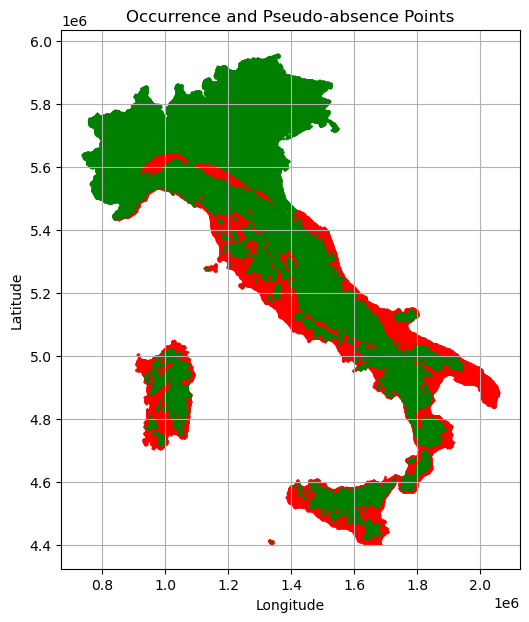

In [48]:
# You can uncomment, if you want to have a look at the clustering. But takes some time to plot 
for i in range(1):
    gdf_pseudo_candidates, gdf_occurence_candidates = get_pseudo_absence_points(samples=100, seed=i)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(7, 7))

    # Plot pseudo-absence candidates
    gdf_pseudo_candidates.plot(ax=ax, color='red', markersize=0.1, label='Pseudo-absence')

    # Plot species occurrence points
    gdf_occurence_candidates.plot(ax=ax, color='green', markersize=0.1, label='Occurrence')

    # Customize plot
    ax.set_title('Occurrence and Pseudo-absence Points')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #ax.legend()
    ax.grid(True)

    # Show plot
    plt.show()

## 4 Model fitting and prediction

We will now divide the data into training data and test data. We then do the basic Machine Learning Approach. Train the data on the training data and validate it against the test data.

One thing to consider is **Spatial autocorrelation** which tends to be a problem in SDM. There seems to be a strong correlation across neighbouring points. This can become a problem when test and training data show signs of autocorrelation which can affect the model's robustness and applicability across different environments.

A simple way to address this is what is called **spatial block cross-validation**, which ensures that there is at least some spatial distance between test and training data. To do so, we divide the our data in larger blocks (squares) of 50km. Then, we make sure that test and training data do not come from the same block.

One method to address this issue is the spatial block cross-validation technique, which involves dividing the data into training and testing datasets. This technique involves dividing the data into multiple blocks, using each block independently as training and test datasets to reduce the impact of spatial autocorrelation. This enhances the independence between datasets, allowing for a more accurate evaluation of the model's generalization ability.

Below is a bit of a spaghetti code, but it should still be easy to follow. We have the following procedure:

0. We divide the data set into spatial blocks of 50km x 50km
1. The blocks are then randomly assigned 3:7 split to be either be a test or training block
2. Then we train a Random Forest to predict the habitat suitability given then environmental predictors
3. We do this for 10 different randomly chosen test and training sets.
4. We average the 10 results to get the final habitat suitability.
5. We compare the metrics of each run for accuracy.

In [49]:
predictor_cols = [col for col in gdf_predictors.columns if col not in ["geometry", "kmeans_cluster", "suitability"]]
suitability_maps = []
accuracies = []
aucs = []

for seed in range(10):
    print(seed)
    # 300 occurrence points
    occ = gdf_species.sample(n=300, random_state=seed).copy()
    occ["label"] = 1
    occ = occ.to_crs(epsg=3857)
    
    # 300 pseudo-absence points
    gdf_pa, _ = get_pseudo_absence_points(samples=100)
    pseudo = gdf_pa.sample(n=300, random_state=seed).copy()
    pseudo["label"] = 0
    pseudo = pseudo.to_crs(epsg=3857)

    # Combine and split
    df = pd.concat([occ, pseudo]).reset_index(drop=True)
    X = df[predictor_cols]
    y = df["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )

    # Train model
    rf = RandomForestClassifier(n_estimators=200, random_state=seed)
    rf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    accuracies.append(acc)
    aucs.append(auc)

    # Predict over habitat image
    habitat_image = gdf_predictors[predictor_cols]
    suitability = rf.predict_proba(habitat_image)[:, 1]
    suitability_maps.append(suitability)

# Average metrics
print(f"Avg Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
print(f"Avg ROC AUC:  {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# Average suitability
avg_suitability = np.mean(suitability_maps, axis=0)
gdf_predictors["suitability"] = avg_suitability


0
1
2
3
4
5
6
7
8
9
Avg Accuracy: 0.969 ± 0.007
Avg ROC AUC:  0.994 ± 0.004


Finally we visualise the results

In [50]:
print(gdf_species.geom_type.unique())

['Point']


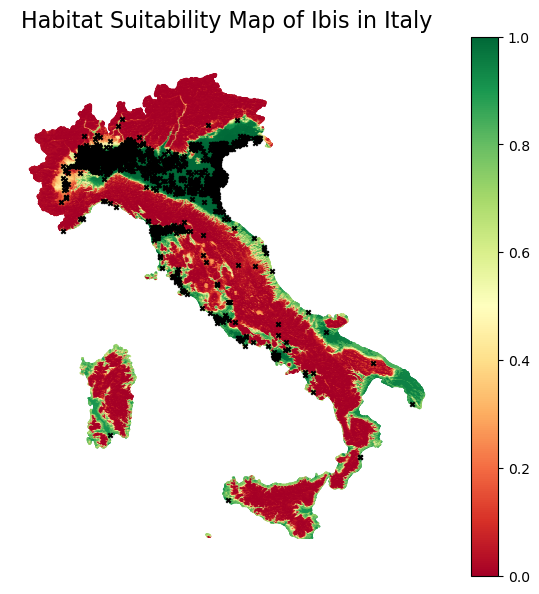

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

gdf_predictors.plot(column="suitability", cmap="RdYlGn", markersize=0.1, ax=ax, legend=True)

# Convert gdf_species to match CRS and extract x and y
gdf_species_proj = gdf_species.to_crs(gdf_predictors.crs)
x = gdf_species_proj.geometry.x
y = gdf_species_proj.geometry.y

# Plot using scatter for more control
ax.scatter(x, y, color='black', s=10, marker='x', alpha=1)


ax.set_title("Habitat Suitability Map of Ibis in Italy", size=16)
ax.axis("off")
#plt.legend()
plt.savefig('output/habitat.png')
plt.show()

The great thing about random forest and the use of pseudo-absence data is that we can use derive the importance of each variable.

The elevation, slope and bio8 are the 3 most important variables (note that slope and elevation are quite related)

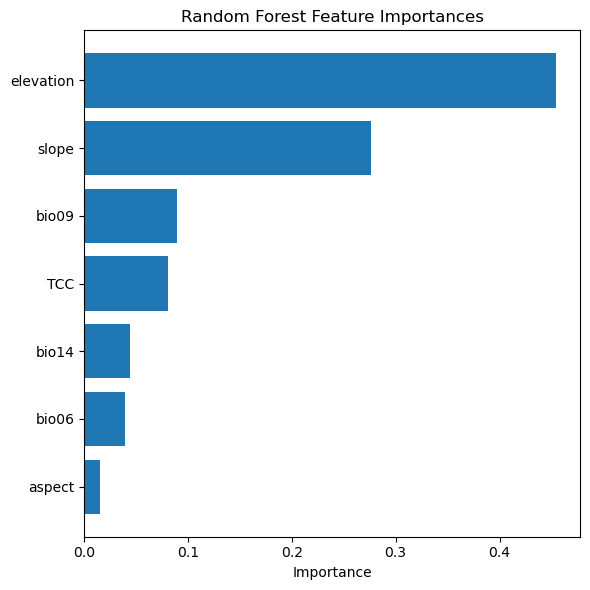

In [ ]:
# Get feature importances from the trained model
importances = rf.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': predictor_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('output/importance.png')
plt.show()

Great, we made it to the end of this tutorial/example.

Once again please have a look at the Google Earth Engine Tutorial which provides more detail in some steps and many more visualisation. The visualisations and interactive maps are definitely the strong suit of this.

Another great sure is [this github page](https://smithsonian.github.io/SDMinGEE/#creating-pseudo-absences), which I think is the basis of the GEE tutorial. It is in JavaScript, but GEE is basically in Javascript anyways.

Finally, I want to draw the attention to a [nature publication on the sacred ibis in Italy](https://www.nature.com/articles/s41598-020-79137-w). Luckily, I am not trying to publish any of this because basically the whole analysis has been done already in 2021. There are further details, especially, on the Ibis bird and its behavior and habitat. They use R (yet another language to solve the same problem). On a positive note, we now have the technical skills to publish in Nature. 